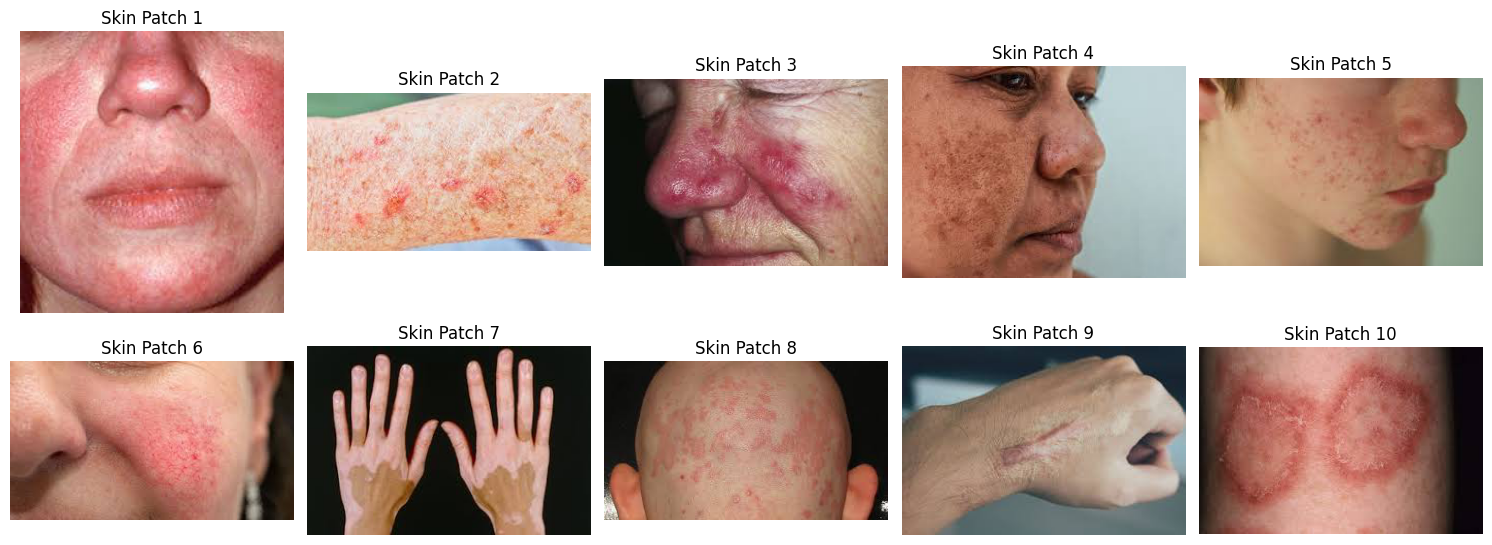

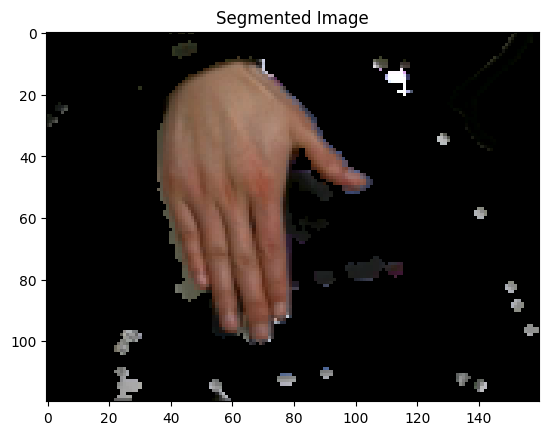

In [16]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def calculate_histogram(images, mask=None):
    hs_histogram = None
    for image in images:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv], [0, 1], mask, [180, 256], [0, 180, 0, 256])
        if hs_histogram is None:
            hs_histogram = hist
        else:
            hs_histogram += hist
    return hs_histogram

def segment_image(image, hs_histogram):
    cv2.normalize(hs_histogram, hs_histogram, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    dst = cv2.calcBackProject([hsv], [0, 1], hs_histogram, [0, 180, 0, 256], 1)

    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    cv2.filter2D(dst, -1, disc, dst)

    _, threshold = cv2.threshold(dst, 50, 255, 0)
    binary = cv2.merge((threshold, threshold, threshold))
    result = cv2.bitwise_and(image, binary)

    return result

def show_images(images, title='Image', cols=5):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'{title} {i+1}')
        plt.axis('off')
    plt.tight_layout(pad=1.0)
    plt.show()

# Path to your skin patches and test image
skin_patches_folder = '/Users/abhishekbasu/Desktop/skin'  # Update this path
test_image_path = '/Users/abhishekbasu/Documents/CS 415 COMPUTER VISION/ASSIGNMENT 3/testing_image.bmp'  # Update this path

# Load skin patches and test image
skin_patches = load_images_from_folder(skin_patches_folder)
test_image = cv2.imread(test_image_path)

# Calculate HS histogram from skin patches
hs_histogram = calculate_histogram(skin_patches)

# Show all skin patches with adjusted spacing
show_images(skin_patches, title='Skin Patch', cols=5)

# Segment the test image using the calculated histogram
segmented_image = segment_image(test_image, hs_histogram)

# Display the segmented result
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.show()

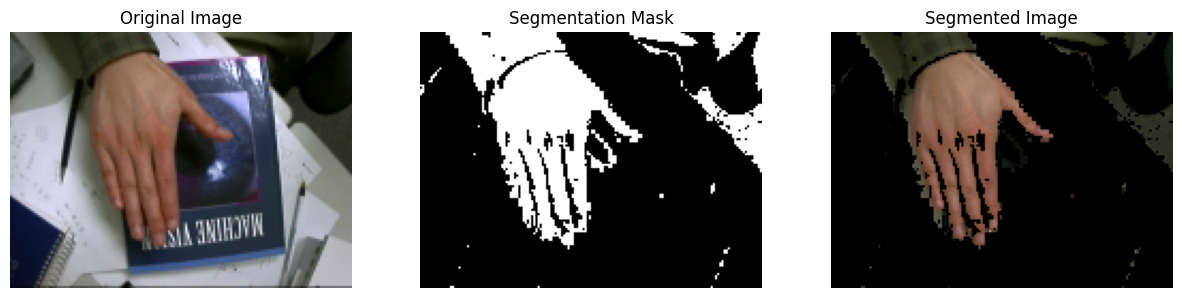

In [17]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm


def calculate_mean_and_covariance(hs_pixels):
    # Calculate mean vector (2D for H and S channels)
    mean_vector = np.mean(hs_pixels, axis=0)
    
    # Calculate covariance matrix (2x2 for H and S channels)
    covariance_matrix = np.cov(hs_pixels, rowvar=False)
    
    return mean_vector, covariance_matrix

def gaussian_probability(x, mean, covariance):
    d = mean.shape[0]
    covariance_det = np.linalg.det(covariance)
    covariance_inv = np.linalg.inv(covariance)
    norm_factor = 1 / (np.sqrt((2 * np.pi) ** d * covariance_det))
    
    # Calculate the exponent part
    x_minus_mean = x - mean
    exponent = -0.5 * np.dot(np.dot(x_minus_mean.T, covariance_inv), x_minus_mean)
    
    return norm_factor * np.exp(exponent)

def build_gaussian_skin_model(image_files):
    hs_pixels = []
    
    for img_file in image_files:
        img = cv2.imread(img_file)
        if img is not None:
            img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            h, s = img_hsv[:, :, 0], img_hsv[:, :, 1]
            hs_pixels.extend(np.column_stack((h.flatten(), s.flatten())))
    
    hs_pixels = np.array(hs_pixels)
    mean_vector, covariance_matrix = calculate_mean_and_covariance(hs_pixels)
    
    return mean_vector, covariance_matrix

def skin_segmentation(img, mean, covariance, threshold):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    height, width, _ = img_hsv.shape
    mask = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(height):
        for j in range(width):
            hs_pixel = np.array([img_hsv[i, j, 0], img_hsv[i, j, 1]])
            prob = gaussian_probability(hs_pixel, mean, covariance)
            if prob > threshold:
                mask[i, j] = 1
    
    return mask

# Load training images
skin_dir = r"/Users/abhishekbasu/Desktop/skin"
training_images = [os.path.join(skin_dir, f) for f in os.listdir(skin_dir) if f.endswith((".png", ".jpeg"))]

# Build Gaussian skin model
mean_vector, covariance_matrix = build_gaussian_skin_model(training_images)

# Test on the testing image
img_test = cv2.imread("testing_image.bmp")
threshold = 4.3*1e-5  # Experiment with this threshold value
mask = skin_segmentation(img_test, mean_vector, covariance_matrix, threshold)

# Apply mask to create segmented image
img_seg = img_test * mask[:, :, None]

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmentation Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB))
plt.title("Segmented Image")
plt.axis("off")

plt.show()

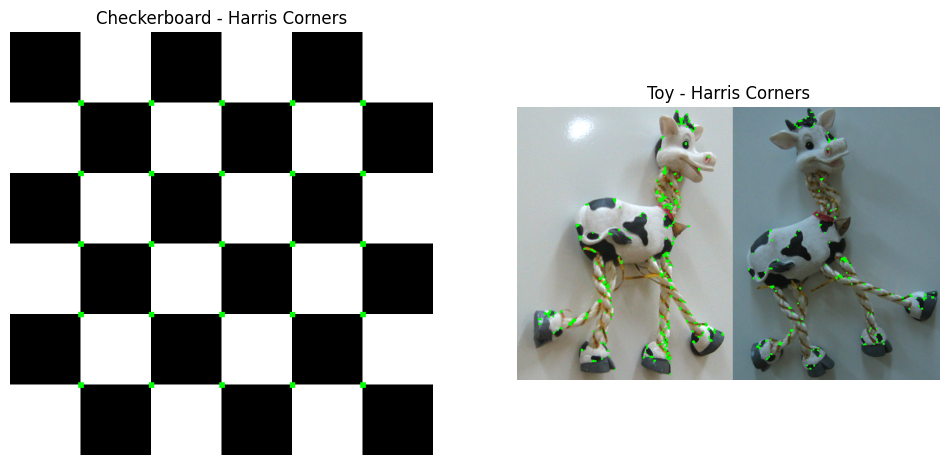

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img_checkerboard = cv2.imread('checkerboard.png')
img_toy = cv2.imread('toy.png')

# Convert to grayscale
gray_checkerboard = cv2.cvtColor(img_checkerboard, cv2.COLOR_BGR2GRAY)
gray_toy = cv2.cvtColor(img_toy, cv2.COLOR_BGR2GRAY)

# Apply Harris Corner Detection
dst_checkerboard = cv2.cornerHarris(gray_checkerboard, 2, 3, 0.04)
dst_toy = cv2.cornerHarris(gray_toy, 2, 3, 0.04)

# Dilate corner image to enhance the detected corners
dst_checkerboard = cv2.dilate(dst_checkerboard, None)
dst_toy = cv2.dilate(dst_toy, None)

# Threshold to identify strong corners
threshold_checkerboard = 0.01 * dst_checkerboard.max()
threshold_toy = 0.01 * dst_toy.max()

# Create copy of the original image to draw on
img_checkerboard_corners = img_checkerboard.copy()
img_toy_corners = img_toy.copy()

# Mark corners on the image with green color
img_checkerboard_corners[dst_checkerboard > threshold_checkerboard] = [0, 255, 0]  # Green corners
img_toy_corners[dst_toy > threshold_toy] = [0, 255, 0]  # Green corners

# Display images with detected corners
plt.figure(figsize=(12, 6))

# Display checkerboard image with corners
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_checkerboard_corners, cv2.COLOR_BGR2RGB))
plt.title('Checkerboard - Harris Corners')
plt.axis('off')

# Display toy image with corners
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_toy_corners, cv2.COLOR_BGR2RGB))
plt.title('Toy - Harris Corners')
plt.axis('off')

plt.show()